# AlphaFin Stage‑1 LoRA and LoRI Fine‑Tuning
This Colab / AutoDL notebook will:
1. Install required libraries
2. (Optionally) login to Hugging Face with your API token
3. Download **ChatGLM2‑6B** base model, **FinGPT LoRA**, and **AlphaFin‑dataset‑v1** **into the Colab runtime** (`/content`)
4. Fine‑tune the FinGPT LoRA on AlphaFin Stage‑1 data (two‑stage training)
5. Evaluate Accuracy & Macro‑F1 on the Stage‑1 test set
6. Plot the training loss curve
7. Copy the new LoRA adapter & plot **to Google Drive** (`My Drive/AlphaFin_Fineturning`)
8. Upload the fine-tuned Model to Hugging face

Simply fill your Hugging Face API token below (or leave blank), then **Runtime ▶ Run all**.

In [ ]:
!pip install -q git-lfs huggingface_hub
with open("/content/main_notebook/huggingface_token.txt", "r") as f:
    huggingface_token = f.read().strip()

!huggingface-cli login --token {huggingface_token}



⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `hf`CLI if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `James_Hugging` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `James_Hugging`


### Clear the GPU video memory


In [ ]:
# 🧹 GPU cleaning (without killing the kernel): del + gc + empty_cache + cuda Device Reset
import torch, gc, ctypes, subprocess, sys

def smi_mem():
    try:
        out = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=memory.used,memory.total", "--format=csv,noheader,nounits"]
        ).decode().strip()
        print("nvidia-smi:", out)
    except Exception as e:
        print("nvidia-smi error:", e)

print("Before:")
smi_mem()
print("torch: allocated=%.1f MB | reserved=%.1f MB" % (
    torch.cuda.memory_allocated()/2**20, torch.cuda.memory_reserved()/2**20))

# 1) ()
for name in ["model","base","trainer","trainer_raw","trainer_cot",
             "tokenizer","optimizer","scheduler","train_raw","train_cot"]:
    if name in globals():
        try:
            del globals()[name]
            print("del", name)
        except Exception as e:
            print("skip", name, e)

# 2) Python Garbage collection + release of unused cache
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    try: torch.cuda.reset_peak_memory_stats()
    except Exception: pass

# 3) Reset the CUDA device context (Key: Release the "stuck" video memory
try:
    libcudart = ctypes.CDLL("libcudart.so")
    ret = libcudart.cudaDeviceReset()
    print("cudaDeviceReset ->", ret)  # 0 
except Exception as e:
    print("cudaDeviceReset failed:", e)

print("\nAfter:")
print("torch: allocated=%.1f MB | reserved=%.1f MB" % (
    torch.cuda.memory_allocated()/2**20, torch.cuda.memory_reserved()/2**20))
smi_mem()


Before:
nvidia-smi: 14573, 40960
torch: allocated=11952.1 MB | reserved=14012.0 MB
del model
del base
del trainer_raw
del trainer_cot
del tokenizer
del train_raw
del train_cot
cudaDeviceReset -> 0

After:
torch: allocated=11952.1 MB | reserved=13900.0 MB
nvidia-smi: 5, 40960


In [ ]:
import torch, os, subprocess, sys
print("torch.cuda.is_available ->", torch.cuda.is_available())
!nvidia-smi || echo "No GPU was detected！"


torch.cuda.is_available -> True
Sun Aug 17 11:34:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+---------------

In [ ]:
# ============================================================
# 1) Hugging Face login
# ============================================================
!pip install -q git-lfs huggingface_hub
with open("/content/main_notebook/huggingface_token.txt", "r") as f:
    huggingface_token = f.read().strip()

!huggingface-cli login --token {huggingface_token}



# ============================================================
# 2) Mount Google Drive(Save the final model & chart)
# ============================================================
from google.colab import drive
drive.mount('/content/drive')

# ============================================================
# 3) Path definition, download model/data
# ============================================================
import os, pathlib, torch, json, re, shutil
BASE_LOCAL  = "/content/alphafin_local"
CHATGLM_DIR = f"{BASE_LOCAL}/chatglm2"
FINGPT_DIR  = f"{BASE_LOCAL}/fingpt_lora"
DATA_DIR    = f"{BASE_LOCAL}/AlphaFin_data"
OUTPUT_DIR  = "/content/finetuned_stage1_lora"

DRIVE_DIR   = "/content/drive/My Drive/AlphaFin_Fineturning"
os.makedirs(DRIVE_DIR, exist_ok=True); os.makedirs(BASE_LOCAL, exist_ok=True)

# ---------- Download ----------
from huggingface_hub import snapshot_download
def need(path): return not os.path.exists(path) or len(os.listdir(path))==0

if need(CHATGLM_DIR):
    snapshot_download("THUDM/chatglm2-6b", local_dir=CHATGLM_DIR, local_dir_use_symlinks=False)
if need(FINGPT_DIR):
    snapshot_download("FinGPT/fingpt-mt_chatglm2-6b_lora", local_dir=FINGPT_DIR, local_dir_use_symlinks=False)
if need(DATA_DIR):
    snapshot_download("AlphaFin/AlphaFin-dataset-v1", repo_type="dataset",
                      local_dir=DATA_DIR, local_dir_use_symlinks=False)

print("All models & data ready.")




⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `hf`CLI if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `James_Hugging` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `James_Hugging`
Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:982: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

configuration_chatglm.py: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

MODEL_LICENSE: 0.00B [00:00, ?B/s]

pytorch_model-00002-of-00007.bin:   0%|          | 0.00/1.97G [00:00<?, ?B/s]

modeling_chatglm.py: 0.00B [00:00, ?B/s]

pytorch_model-00001-of-00007.bin:   0%|          | 0.00/1.83G [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

pytorch_model-00003-of-00007.bin:   0%|          | 0.00/1.93G [00:00<?, ?B/s]

pytorch_model-00004-of-00007.bin:   0%|          | 0.00/1.82G [00:00<?, ?B/s]

pytorch_model-00005-of-00007.bin:   0%|          | 0.00/1.97G [00:00<?, ?B/s]

pytorch_model.bin.index.json: 0.00B [00:00, ?B/s]

pytorch_model-00006-of-00007.bin:   0%|          | 0.00/1.93G [00:00<?, ?B/s]

pytorch_model-00007-of-00007.bin:   0%|          | 0.00/1.05G [00:00<?, ?B/s]

quantization.py: 0.00B [00:00, ?B/s]

tokenization_chatglm.py: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/1.02M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

README.md:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

adapter_model.bin:   0%|          | 0.00/3.91M [00:00<?, ?B/s]

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

research.json: 0.00B [00:00, ?B/s]

stockqa.json: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

fin_news.json: 0.00B [00:00, ?B/s]

fin_reports_cot.json: 0.00B [00:00, ?B/s]

1000_report_marketdata.json: 0.00B [00:00, ?B/s]

train/fin_reports_raw.json:   0%|          | 0.00/101M [00:00<?, ?B/s]

train/research.json:   0%|          | 0.00/88.0M [00:00<?, ?B/s]

train/fin_news.json:   0%|          | 0.00/199M [00:00<?, ?B/s]

train/stockqa.json:   0%|          | 0.00/42.1M [00:00<?, ?B/s]

✅ All models & data ready.


In [ ]:
# GPU cleaning (without killing the kernel): del + gc + empty_cache + cuda Device Reset
import torch, gc, ctypes, subprocess, sys

def smi_mem():
    try:
        out = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=memory.used,memory.total", "--format=csv,noheader,nounits"]
        ).decode().strip()
        print("nvidia-smi:", out)
    except Exception as e:
        print("nvidia-smi error:", e)

print("Before:")
smi_mem()
print("torch: allocated=%.1f MB | reserved=%.1f MB" % (
    torch.cuda.memory_allocated()/2**20, torch.cuda.memory_reserved()/2**20))

# 1) ()
for name in ["model","base","trainer","trainer_raw","trainer_cot",
             "tokenizer","optimizer","scheduler","train_raw","train_cot"]:
    if name in globals():
        try:
            del globals()[name]
            print("del", name)
        except Exception as e:
            print("skip", name, e)

# 2) Python Garbage collection + release of unused cache
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    try: torch.cuda.reset_peak_memory_stats()
    except Exception: pass

# 3) Reset the CUDA device context (Key: Release the "stuck" video memory
try:
    libcudart = ctypes.CDLL("libcudart.so")
    ret = libcudart.cudaDeviceReset()
    print("cudaDeviceReset ->", ret)  # 0
except Exception as e:
    print("cudaDeviceReset failed:", e)

print("\nAfter:")
print("torch: allocated=%.1f MB | reserved=%.1f MB" % (
    torch.cuda.memory_allocated()/2**20, torch.cuda.memory_reserved()/2**20))
smi_mem()


Before:
nvidia-smi: 5, 40960
torch: allocated=16.2 MB | reserved=102.0 MB
cudaDeviceReset -> 0

After:
torch: allocated=16.2 MB | reserved=102.0 MB
nvidia-smi: 5, 40960


### LoRA

Base=/content/alphafin_local/chatglm2
LoRA=/content/alphafin_local/fingpt_lora
Data=/content/alphafin_local/AlphaFin_data
Out =/content/finetuned_stage1_lora
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
⚙️ Effective batch size = 16
PAD_ID = 2


Generating train split: 0 examples [00:00, ? examples/s]

🔄 Tokenizing RAW(train):   0%|          | 0/19989 [00:00<?, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

🔄 Tokenizing CoT(train):   0%|          | 0/200 [00:00<?, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

🚀 Loading ChatGLM2-6B via CPU(FP32) → GPU …


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


✅ model device: cuda:0 | dtype: torch.bfloat16
🔹 LoRA on: cuda:0 | dtype: torch.bfloat16


/tmp/ipython-input-1861729140.py:271: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_raw = Trainer(


/tmp/ipython-input-1861729140.py:302: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_cot = Trainer(


🔐 Adapter copied to /content/drive/My Drive/AlphaFin_Fineturning/finetuned_stage1_lora


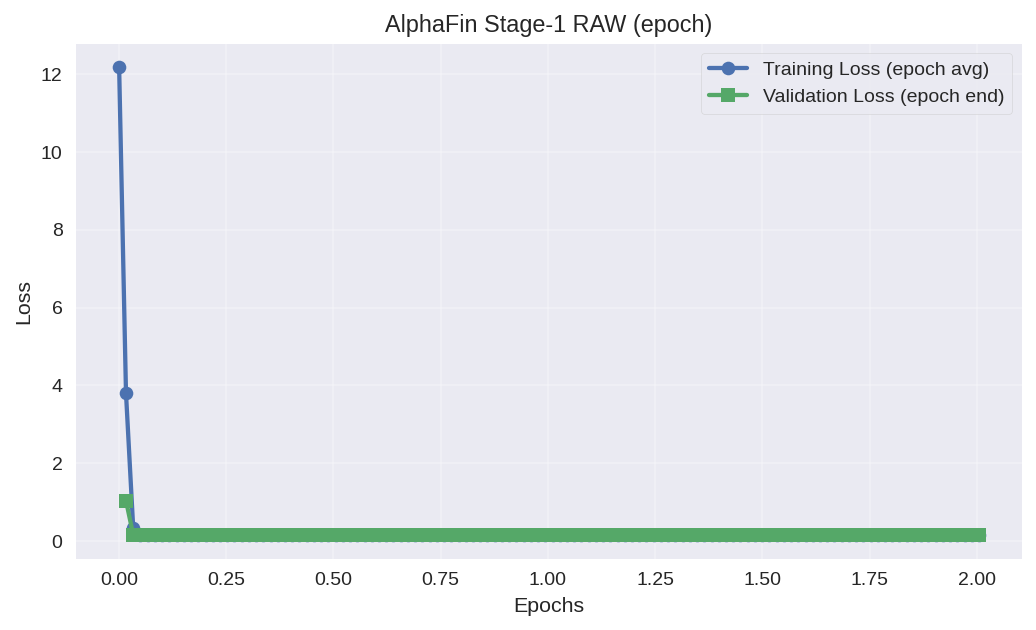

📈 Saved loss curve to: /content/finetuned_stage1_lora/loss_curve_raw.png and Drive


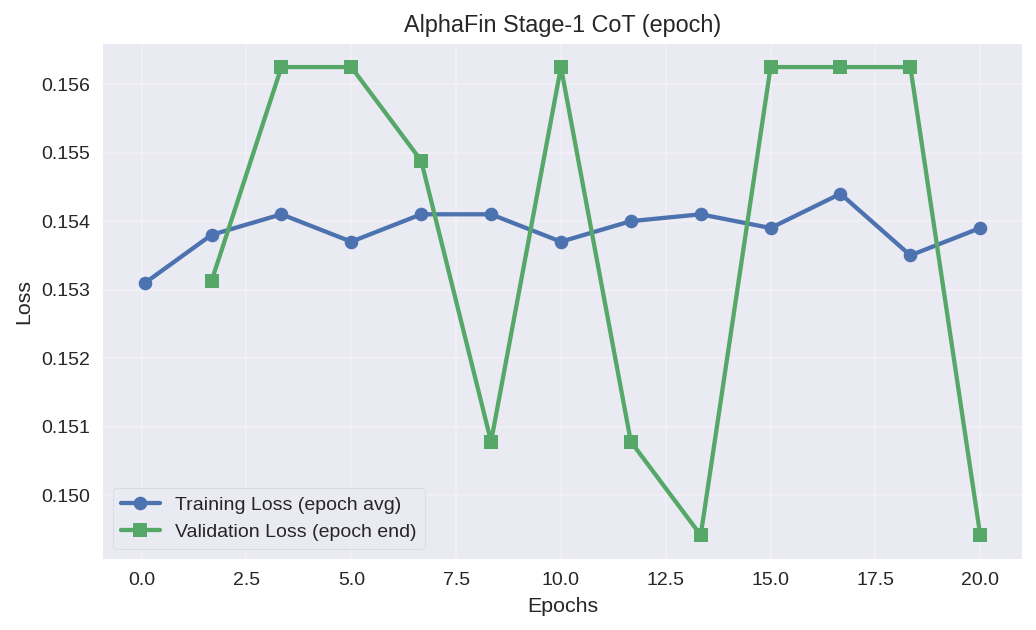

📈 Saved loss curve to: /content/finetuned_stage1_lora/loss_curve_cot.png and Drive


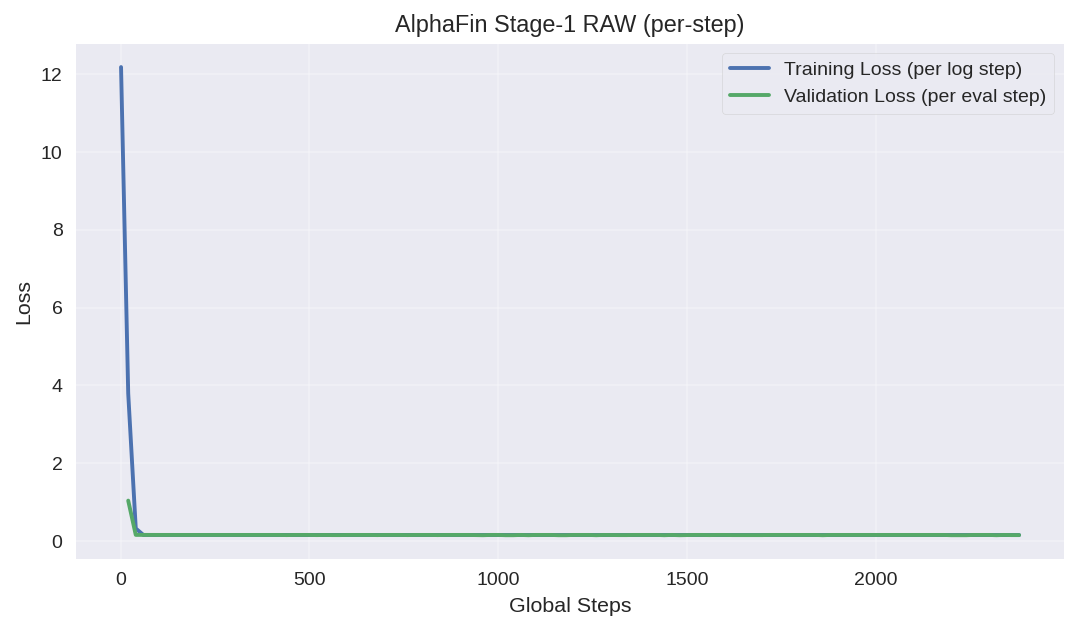

📈 Saved step loss curve to: /content/finetuned_stage1_lora/loss_curve_raw_steps.png and Drive


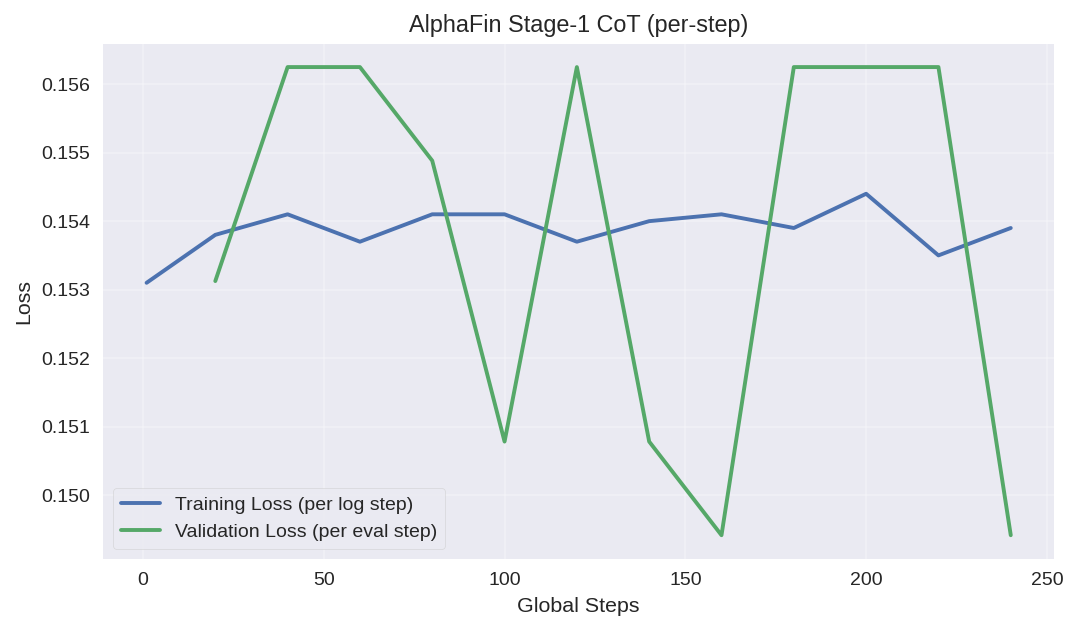

📈 Saved step loss curve to: /content/finetuned_stage1_lora/loss_curve_cot_steps.png and Drive
Accuracy: 0.0
Macro-F1: 0.0


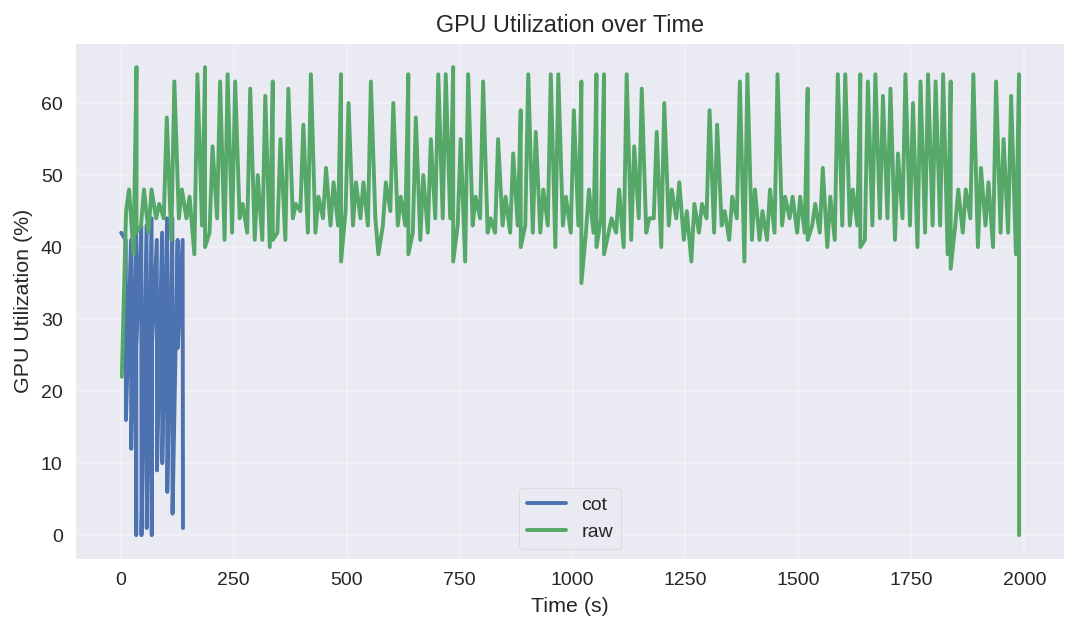

📊 Saved resource curve to: /content/finetuned_stage1_lora/gpu_util_curve.png and Drive


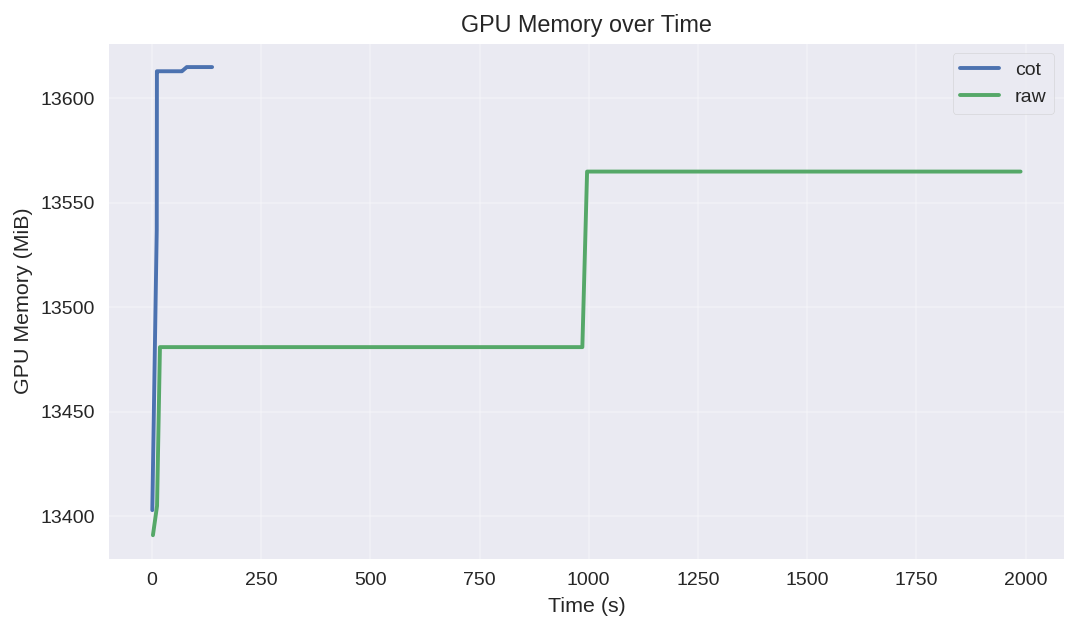

📊 Saved resource curve to: /content/finetuned_stage1_lora/gpu_mem_curve.png and Drive


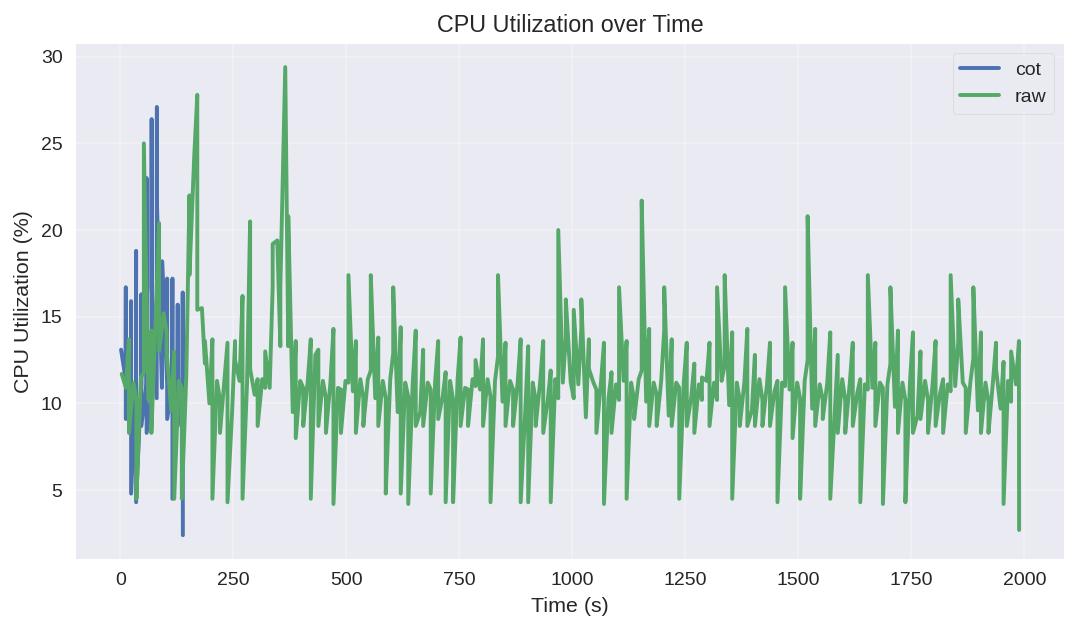

📊 Saved resource curve to: /content/finetuned_stage1_lora/cpu_util_curve.png and Drive


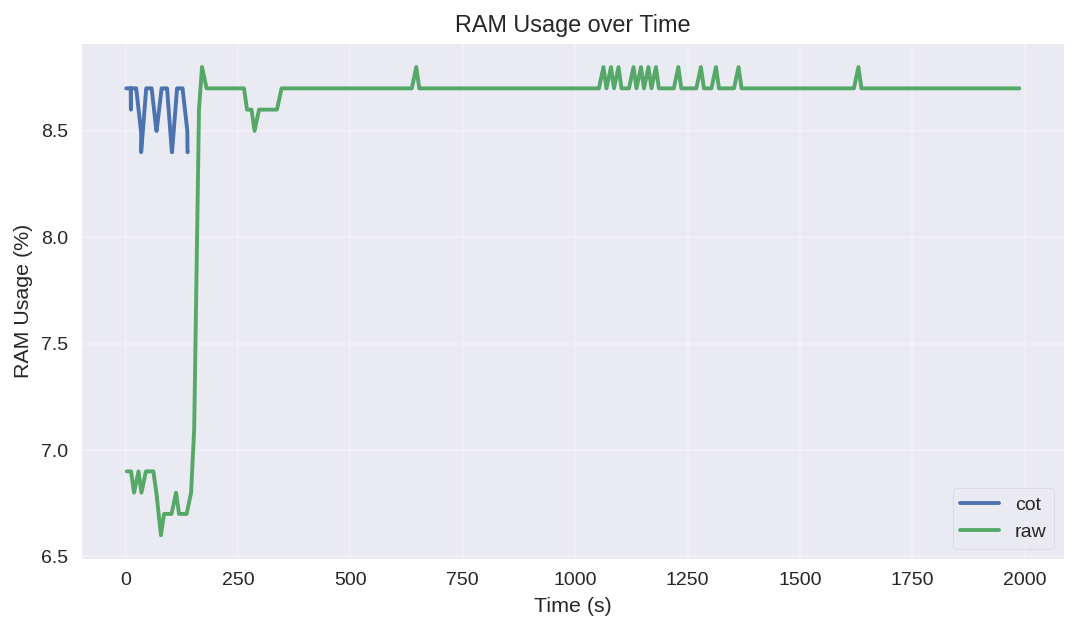

📊 Saved resource curve to: /content/finetuned_stage1_lora/ram_curve.png and Drive
🧾 Saved resource_samples.csv to OUTPUT_DIR and Drive.

===== nvidia-smi snapshot =====
Wed Aug 20 16:50:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             64W /  400W |   13615MiB /  40960

In [ ]:
# ================================================================
# A100 : Fine-tune FinGPT LoRA on AlphaFin Stage-1
#1.no quant | BF16/TF32 | Two-stage: Continuous verification (step by step) + early stop after at least half the journey
#2.Loading logic: CPU(FP32)→GPU→BF16/FP16 | Curve display| Resource Monitoring| Save Drive)
# ================================================================
import os, sys, re, json, shutil, time, subprocess, psutil, torch, inspect, math
from pathlib import Path
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, TrainingArguments, Trainer, TrainerCallback
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from IPython.display import display

# ----------------Define Path ----------------
CHATGLM_DIR = globals().get("CHATGLM_DIR", "/content/alphafin_local/chatglm2")
FINGPT_DIR  = globals().get("FINGPT_DIR" , "/content/alphafin_local/fingpt_lora")
DATA_DIR    = globals().get("DATA_DIR"   , "/content/alphafin_local/AlphaFin_data")
OUTPUT_DIR  = globals().get("OUTPUT_DIR" , "/content/finetuned_stage1_lora")
print(f"Base={CHATGLM_DIR}\nLoRA={FINGPT_DIR}\nData={DATA_DIR}\nOut ={OUTPUT_DIR}")

# ---------------- Google Drive ----------------
DRIVE_DIR = "/content/drive/My Drive/AlphaFin_Fineturning"
try:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=False)
    os.makedirs(DRIVE_DIR, exist_ok=True)
except Exception:
    pass

assert torch.cuda.is_available(), "Please first switch from Colab/AutoDL to GPU runtime."
device = torch.device("cuda", 0)
cc = torch.cuda.get_device_capability(0)   # (8,0) for A100
A100_BF16 = (cc[0] >= 8)

# A100 : General acceleration: TF32 / matmul high precision
torch.backends.cuda.matmul.allow_tf32 = True
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

# Train parameters
MAX_LEN          = 512
BATCH_PER_DEV    = 4       # 4 * 4 = 16 batch
GRAD_ACCUM_STEPS = 4
EPOCHS_RAW       = 4
EPOCHS_COT       = 20
NUM_WORKERS      = 8
USE_GRAD_CHKPT   = False
LEARNING_RATE    = 5e-5
print(f"Effective batch size = {BATCH_PER_DEV * GRAD_ACCUM_STEPS}")

PROMPT = (
    "请根据以下研究报告与市场数据，预测该股票下月走势，只回答 up 或 down。\n"
    "<report>\n{report}\n"
    "<market_data>\n{market}\n"
    "答案："
)

# ---------------- Tokenizer( pad; _pad ) ----------------
tokenizer = AutoTokenizer.from_pretrained(CHATGLM_DIR, trust_remote_code=True)
tokenizer.padding_side = "left"
PAD_ID = getattr(tokenizer, "pad_token_id", None) or getattr(tokenizer, "eos_token_id", None) or 0
print("PAD_ID =", PAD_ID)

if hasattr(tokenizer, "_pad"):
    try:
        sig = inspect.signature(tokenizer._pad)
        if "padding_side" not in sig.parameters:
            _orig_pad = tokenizer._pad
            def _pad_compat(*args, **kwargs):
                kwargs.pop("padding_side", None)
                return _orig_pad(*args, **kwargs)
            tokenizer._pad = _pad_compat
    except Exception:
        pass

# ----------------Datasets----------------
def build_dataset(json_file, tokenizer, max_len=MAX_LEN, desc="Tokenizing"):
    ds = load_dataset("json", data_files=str(json_file), split="train")
    def _map(ex):
        text = PROMPT.format(
            report = ex.get("report", ex.get("text","")),
            market = ex.get("market_data","")
        ) + ex.get("label","")
        ids = tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=max_len)
        return {"input_ids": ids, "labels": ids.copy()}
    return ds.map(_map, remove_columns=ds.column_names, desc=desc)

raw_full = build_dataset(Path(DATA_DIR)/"train/fin_reports_raw.json", tokenizer, desc="🔄 Tokenizing RAW(train)")
cot_full = build_dataset(Path(DATA_DIR)/"train/fin_reports_cot.json", tokenizer, desc="🔄 Tokenizing CoT(train)")
raw_splits = raw_full.train_test_split(test_size=0.05, seed=42)
cot_splits = cot_full.train_test_split(test_size=0.05, seed=42)
train_raw, valid_raw = raw_splits["train"], raw_splits["test"]
train_cot, valid_cot = cot_splits["train"], cot_splits["test"]

test_ds = load_dataset("json", data_files=str(Path(DATA_DIR)/"test/1000_report_marketdata.json"), split="train")

# ----------------Disable bitsandbytes(avoid triton.ops) ----------------
def disable_bitsandbytes():
    try:
        import bitsandbytes
        print("↯ Detected bitsandbytes, uninstalling…")
        subprocess.run([sys.executable, "-m", "pip", "uninstall", "-y", "bitsandbytes"],
                       check=False, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    except Exception:
        pass
    for k in list(sys.modules.keys()):
        if k.startswith("bitsandbytes"):
            del sys.modules[k]
disable_bitsandbytes()

# ---------------- Robust loading: CPU(FP32) → GPU → BF16/FP16() ----------------
print("Loading ChatGLM2-6B via CPU(FP32) → GPU …")
base = AutoModel.from_pretrained(
    CHATGLM_DIR,
    torch_dtype=torch.float32,    # CPU FP32
    device_map="cpu",
    trust_remote_code=True,
    low_cpu_mem_usage=False,
)
base = base.to(device)            # Move to GPU first
base = base.to(dtype=(torch.bfloat16 if A100_BF16 else torch.float16))

# GPU memory/Speed settings
if USE_GRAD_CHKPT:
    try:
        base.gradient_checkpointing_enable(gradient_checkpointing_kwargs={"use_reentrant": False})
    except TypeError:
        base.gradient_checkpointing_enable()
else:
    base.gradient_checkpointing_disable()
base.config.use_cache = False
try: base.config.pad_token_id = PAD_ID
except Exception: pass
print("model device:", next(base.parameters()).device, "| dtype:", next(base.parameters()).dtype)

# ---------------- LoRA-on-LoRA ----------------
from peft import PeftModel
model = PeftModel.from_pretrained(base, FINGPT_DIR, is_trainable=True)
print("🔹 LoRA on:", next(model.parameters()).device, "| dtype:", next(model.parameters()).dtype)

# ---------------- Collate ----------------
from torch.nn.utils.rnn import pad_sequence
def collate_fn(features):
    ids  = [torch.tensor(f["input_ids"], dtype=torch.long) for f in features]
    labs = [torch.tensor(f["labels"],    dtype=torch.long) for f in features]
    ids_p  = pad_sequence(ids,  batch_first=True, padding_value=PAD_ID)
    labs_p = pad_sequence(labs, batch_first=True, padding_value=-100)
    attn   = (ids_p != PAD_ID).long()
    return {"input_ids": ids_p, "labels": labs_p, "attention_mask": attn}

# ---------------- Training Arguments Compatible----------------
def TA(**kwargs):
    sig = inspect.signature(TrainingArguments.__init__)
    params = set(sig.parameters.keys())
    allowed = {k: v for k, v in kwargs.items() if k in params}
    for k in ["evaluation_strategy", "save_strategy", "load_best_model_at_end",
              "metric_for_best_model", "greater_is_better", "eval_steps", "save_steps",
              "logging_strategy", "logging_first_step"]:
        if k not in params:
            allowed.pop(k, None)
    return TrainingArguments(**allowed)

# ----------------Computing Resource monitoring----------------
class ResourceMonitor(TrainerCallback):
    def __init__(self, tag):
        self.tag = tag
        self.t0  = time.time()
        self.logs = []
    def sample(self, step=None):
        try:
            out = subprocess.check_output(
                ["nvidia-smi", "--query-gpu=utilization.gpu,memory.used",
                 "--format=csv,noheader,nounits"],
                encoding="utf-8"
            ).strip().splitlines()[0]
            gpu_util, gpu_mem = [int(x.strip()) for x in out.split(",")]
        except Exception:
            gpu_util, gpu_mem = -1, -1
        try:
            cpu_util = psutil.cpu_percent(interval=None)
            ram = psutil.virtual_memory().percent
        except Exception:
            cpu_util, ram = -1, -1
        self.logs.append({
            "t": time.time() - self.t0,
            "step": step if step is not None else -1,
            "gpu_util": gpu_util,
            "gpu_mem": gpu_mem,
            "cpu_util": cpu_util,
            "ram": ram,
            "phase": self.tag
        })
    def on_log(self, args, state, control, logs=None, **kwargs):
        self.sample(step=int(state.global_step))

# Continuous assessment (in on_log trigger, ensure training loss has written) + early stop (at least more than half)
class EvalEveryNSteps(TrainerCallback):
    """When the training loss of the current step has been written to the log (on_log), evaluate is triggered at a fixed number of steps"""
    def __init__(self, eval_steps):
        self.eval_steps = max(1, int(eval_steps))
        self.trainer = None
        self._last_eval_step = -1
    def set_trainer(self, t): self.trainer = t
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None or "loss" not in logs:
            return
        step = int(state.global_step or 0)
        if step > 0 and (step % self.eval_steps == 0) and step != self._last_eval_step:
            if self.trainer is not None and self.trainer.eval_dataset is not None:
                metrics = self.trainer.evaluate()
                metrics = dict(metrics)
                metrics.setdefault("step", step)   # ""
                self.trainer.log(metrics)
                self._last_eval_step = step

class EarlyStopMinEpochs(TrainerCallback):
    """patience (based on the number of evaluations). It is triggered only when epoch >= min_epochs; Monitor eval_loss (the smaller, the better)"""
    def __init__(self, patience=5, min_epochs=1, metric="eval_loss", smaller_is_better=True):
        self.patience = int(patience)
        self.min_epochs = int(min_epochs)
        self.metric = metric
        self.smaller_is_better = smaller_is_better
        self.best = None
        self.bad = 0
    def _is_better(self, cur, best):
        if best is None: return True
        return (cur < best) if self.smaller_is_better else (cur > best)
    def on_evaluate(self, args, state, control, metrics, **kwargs):
        cur = metrics.get(self.metric, None)
        if cur is None:
            return
        epoch = float(state.epoch or 0.0)
        if self._is_better(cur, self.best):
            self.best = cur
            self.bad = 0
        else:
            self.bad += 1
            if (epoch >= self.min_epochs) and (self.bad >= self.patience):
                control.should_training_stop = True

# ---------------- Training arguments ----------------
common_args = dict(
    per_device_train_batch_size = BATCH_PER_DEV,
    gradient_accumulation_steps = GRAD_ACCUM_STEPS,
    learning_rate               = LEARNING_RATE,
    lr_scheduler_type           = "cosine",
    optim                       = "adamw_torch_fused",
    bf16                        = A100_BF16,
    fp16                        = not A100_BF16,
    logging_steps               = 20,
    report_to                   = "none",
    disable_tqdm                = False,
    dataloader_pin_memory       = True,
    dataloader_num_workers      = NUM_WORKERS,
    dataloader_prefetch_factor  = 4,
)
EVAL_EVERY_STEPS = common_args["logging_steps"]

# ---------------- Step1: Report RAW fine-tuning----------------
monitor_raw    = ResourceMonitor("raw")
step_eval_raw  = EvalEveryNSteps(EVAL_EVERY_STEPS)
earlystop_raw  = EarlyStopMinEpochs(
    patience=5,
    min_epochs=max(1, math.ceil(EPOCHS_RAW * 0.5)),
    metric="eval_loss",
    smaller_is_better=True
)

trainer_raw = Trainer(
    model=model,
    args=TA(
        output_dir="/content/run_raw",
        num_train_epochs=EPOCHS_RAW,
        evaluation_strategy="no",
        eval_steps=EVAL_EVERY_STEPS,
        save_steps=EVAL_EVERY_STEPS,
        logging_strategy="steps",
        logging_first_step=True,
    **common_args),
    train_dataset=train_raw,
    eval_dataset=valid_raw,
    tokenizer=tokenizer,
    data_collator=collate_fn,
    callbacks=[monitor_raw, step_eval_raw, earlystop_raw],
)
step_eval_raw.set_trainer(trainer_raw)
trainer_raw.train()

# ---------------- Step2: Report CoT fine-tuning----------------
monitor_cot    = ResourceMonitor("cot")
step_eval_cot  = EvalEveryNSteps(EVAL_EVERY_STEPS)
earlystop_cot  = EarlyStopMinEpochs(
    patience=5,
    min_epochs=max(1, math.ceil(EPOCHS_COT * 0.5)),
    metric="eval_loss",
    smaller_is_better=True
)

trainer_cot = Trainer(
    model=model,
    args=TA(
        output_dir="/content/run_cot",
        num_train_epochs=EPOCHS_COT,
        evaluation_strategy="no",
        save_strategy="epoch",
        eval_steps=EVAL_EVERY_STEPS,
        save_steps=EVAL_EVERY_STEPS,
        logging_strategy="steps",
        logging_first_step=True,
    **common_args),
    train_dataset=train_cot,
    eval_dataset=valid_cot,
    tokenizer=tokenizer,
    data_collator=collate_fn,
    callbacks=[monitor_cot, step_eval_cot, earlystop_cot],
)
step_eval_cot.set_trainer(trainer_cot)
trainer_cot.train()

# ----------------Save LoRA to Google Drive ----------------
os.makedirs(OUTPUT_DIR, exist_ok=True)
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
dst = f"{DRIVE_DIR}/finetuned_stage1_lora"
try:
    shutil.copytree(OUTPUT_DIR, dst, dirs_exist_ok=True)
    print("Adapter copied to", dst)
except Exception as e:
    print("⚠拷贝到 Google Drive 失败：", e)

# ============================================================
# Curve Drawing(epoch + per-step)
# ============================================================
plt.style.use("seaborn-v0_8")

def _epoch_curves_from_logs(log_hist):
    trn = {}; val = {}
    for rec in log_hist:
        ep = rec.get("epoch", None)
        if ep is None:
            continue
        if "loss" in rec:      trn.setdefault(ep, []).append(float(rec["loss"]))
        if "eval_loss" in rec: val[ep] = float(rec["eval_loss"])
    te = sorted(trn.keys()); tl = [sum(trn[e])/max(1,len(trn[e])) for e in te]
    ve = sorted(val.keys());  vl = [val[e] for e in ve]
    return (te, tl), (ve, vl)

def _step_curves_from_logs(log_hist):
    ts, tl = [], []
    es, ev = [], []
    for rec in log_hist:
        st = rec.get("step", rec.get("global_step", None))
        if st is None: continue
        if "loss" in rec:      ts.append(int(st)); tl.append(float(rec["loss"]))
        if "eval_loss" in rec: es.append(int(st)); ev.append(float(rec["eval_loss"]))
    return (ts, tl), (es, ev)

def _plot_epoch_loss(trainer, title, save_name):
    (te, tl), (ve, vl) = _epoch_curves_from_logs(trainer.state.log_history)
    fig, ax = plt.subplots(figsize=(7.5, 4.6), dpi=140)
    if te: ax.plot(te, tl, marker="o", linewidth=2.2, label="Training Loss (epoch avg)")
    if ve: ax.plot(ve, vl, marker="s", linewidth=2.2, label="Validation Loss (epoch end)")
    ax.set_xlabel("Epochs"); ax.set_ylabel("Loss"); ax.set_title(title)
    ax.grid(True, alpha=0.25); ax.legend(frameon=True)
    fig.tight_layout()
    path_local = os.path.join(OUTPUT_DIR, save_name); fig.savefig(path_local, bbox_inches="tight")
    display(fig); plt.close(fig)
    try:
        shutil.copy(path_local, os.path.join(DRIVE_DIR, save_name))
        print("Saved loss curve to:", path_local, "and Drive")
    except Exception as e:
        print("Save loss curve to Drive failed:", e)

def _plot_step_loss(trainer, title, save_name):
    (ts, tl), (es, ev) = _step_curves_from_logs(trainer.state.log_history)
    fig, ax = plt.subplots(figsize=(7.8, 4.6), dpi=140)
    if ts: ax.plot(ts, tl, linewidth=2.0, label="Training Loss (per log step)")
    if es: ax.plot(es, ev, linewidth=2.0, label="Validation Loss (per eval step)")
    ax.set_xlabel("Global Steps"); ax.set_ylabel("Loss"); ax.set_title(title)
    ax.grid(True, alpha=0.25); ax.legend(frameon=True)
    fig.tight_layout()
    path_local = os.path.join(OUTPUT_DIR, save_name); fig.savefig(path_local, bbox_inches="tight")
    display(fig); plt.close(fig)
    try:
        shutil.copy(path_local, os.path.join(DRIVE_DIR, save_name))
        print("Saved step loss curve to:", path_local, "and Drive")
    except Exception as e:
        print("Save step loss curve to Drive failed:", e)

_plot_epoch_loss(trainer_raw, "AlphaFin Stage-1 RAW (epoch)", "loss_curve_raw.png")
_plot_epoch_loss(trainer_cot, "AlphaFin Stage-1 CoT (epoch)", "loss_curve_cot.png")
_plot_step_loss(trainer_raw, "AlphaFin Stage-1 RAW (per-step)", "loss_curve_raw_steps.png")
_plot_step_loss(trainer_cot, "AlphaFin Stage-1 CoT (per-step)", "loss_curve_cot_steps.png")

# ============================================================
# Independent test set Evaluation (Accuracy & Macro-F1)
#  Greedy decoding (to avoid compatibility issues with the old ChatGLM generate() version)
# ============================================================
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def infer(prompt, max_new_tokens=8):
    model.eval()
    #  Left pad: constructing attention_mask
    toks = tokenizer(prompt, return_tensors="pt", add_special_tokens=True)
    input_ids = toks["input_ids"].to(device)
    attn = (input_ids != PAD_ID).long().to(device)

    with torch.no_grad():
        cur_ids = input_ids
        cur_attn = attn
        for _ in range(max_new_tokens):
            out = model(input_ids=cur_ids, attention_mask=cur_attn)
            # Compatible with different output structures
            logits = out.logits if hasattr(out, "logits") else out[0]
            next_id = int(torch.argmax(logits[:, -1, :], dim=-1))
            next_id_tensor = torch.tensor([[next_id]], device=device, dtype=cur_ids.dtype)
            cur_ids = torch.cat([cur_ids, next_id_tensor], dim=1)
            #  Update attention_mask
            add_mask = torch.ones((cur_attn.size(0), 1), dtype=cur_attn.dtype, device=device)
            cur_attn = torch.cat([cur_attn, add_mask], dim=1)
            # : Early stop: when encountered eos
            eos_id = getattr(tokenizer, "eos_token_id", None)
            if eos_id is not None and next_id == eos_id:
                break

    txt = tokenizer.decode(cur_ids[0], skip_special_tokens=True)
    m = re.search(r"(up|down)", txt, re.I)
    return m.group(1).lower() if m else "unknown"

y_true, y_pred = [], []
for ex in test_ds:
    pr = PROMPT.format(report=ex.get("report", ex.get("text","")),
                       market=ex.get("market_data",""))
    y_true.append(ex.get("label",""))
    y_pred.append(infer(pr))

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Macro-F1:", f1_score(y_true, y_pred, average="macro"))

# ============================================================
# Computing resource curve + original sample saving
# ============================================================
import pandas as pd
def to_df(monitor):
    if not monitor.logs:
        return pd.DataFrame(columns=["t","step","gpu_util","gpu_mem","cpu_util","ram","phase"])
    return pd.DataFrame(monitor.logs)

df_raw = to_df(monitor_raw)
df_cot = to_df(monitor_cot)
df_all = pd.concat([df_raw, df_cot], ignore_index=True)

def _plot_resource(df, y, ylabel, title, save_name):
    if df.empty:
        print("No samples for", title); return
    fig, ax = plt.subplots(figsize=(7.8, 4.6), dpi=140)
    for phase, g in df.groupby("phase"):
        ax.plot(g["t"], g[y], label=phase, linewidth=2.0)
    ax.set_xlabel("Time (s)"); ax.set_ylabel(ylabel); ax.set_title(title)
    ax.grid(True, alpha=0.25); ax.legend(frameon=True)
    fig.tight_layout()
    path_local = os.path.join(OUTPUT_DIR, save_name); fig.savefig(path_local, bbox_inches="tight")
    display(fig); plt.close(fig)
    try:
        shutil.copy(path_local, os.path.join(DRIVE_DIR, save_name))
        print("Saved resource curve to:", path_local, "and Drive")
    except Exception as e:
        print("Save resource curve to Drive failed:", e)

_plot_resource(df_all, "gpu_util", "GPU Utilization (%)", "GPU Utilization over Time", "gpu_util_curve.png")
_plot_resource(df_all, "gpu_mem",  "GPU Memory (MiB)",   "GPU Memory over Time",     "gpu_mem_curve.png")
_plot_resource(df_all, "cpu_util", "CPU Utilization (%)", "CPU Utilization over Time","cpu_util_curve.png")
_plot_resource(df_all, "ram",      "RAM Usage (%)",        "RAM Usage over Time",      "ram_curve.png")

try:
    df_all.to_csv(os.path.join(OUTPUT_DIR, "resource_samples.csv"), index=False)
    shutil.copy(os.path.join(OUTPUT_DIR, "resource_samples.csv"),
                os.path.join(DRIVE_DIR, "resource_samples.csv"))
    print("Saved resource_samples.csv to OUTPUT_DIR and Drive.")
except Exception as e:
    print("Save resource_samples.csv to Drive failed:", e)

print("\n===== nvidia-smi snapshot =====")
try:
    print(subprocess.check_output(["nvidia-smi"], encoding="utf-8"))
except Exception as e:
    print("nvidia-smi failed:", e)


### LoRI

Base=/content/alphafin_local/chatglm2
LoRA/LoRI base=/content/alphafin_local/fingpt_lora
Data=/content/alphafin_local/AlphaFin_data
Out =/content/finetuned_stage1_lora
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
⚙️ Effective batch size = 16
PAD_ID = 2
🚀 Loading ChatGLM2-6B via CPU(FP32) → GPU …


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


✅ model device: cuda:0 | dtype: torch.bfloat16
🔹 LoRA (pre-LoRI) on: cuda:0 | dtype: torch.bfloat16
✅ LoRI applied for RAW: masked B modules = 28, sparsity=0.5


🔄 Tokenizing RAW:   0%|          | 0/19989 [00:00<?, ? examples/s]

/tmp/ipython-input-2590106058.py:317: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_raw = Trainer(


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✅ LoRI applied for CoT: masked B modules = 28, sparsity=0.5


/tmp/ipython-input-2590106058.py:355: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_cot = Trainer(


🔐 LoRI Adapter copied to /content/drive/My Drive/AlphaFin_Fineturning/finetuned_stage1_lora_lori


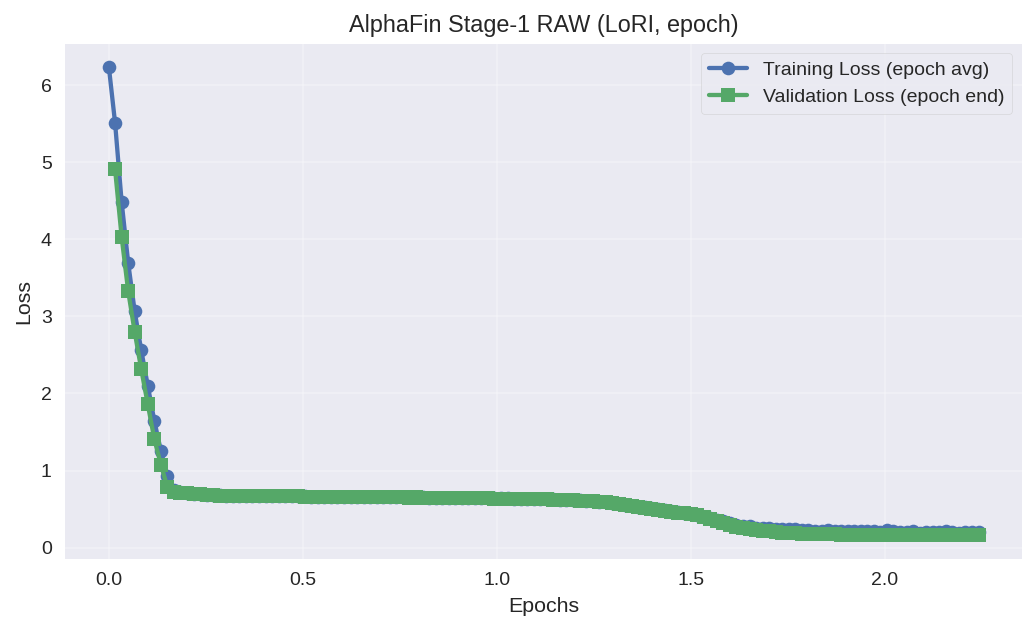

📈 Saved epoch loss curve to: /content/finetuned_stage1_lora/loss_curve_raw_lori.png and Drive


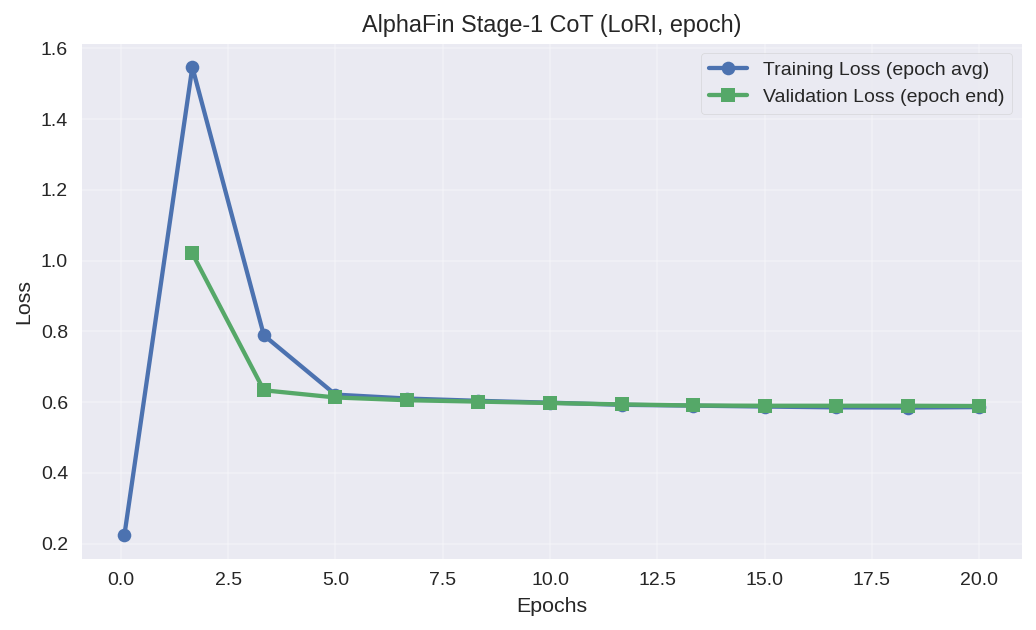

📈 Saved epoch loss curve to: /content/finetuned_stage1_lora/loss_curve_cot_lori.png and Drive


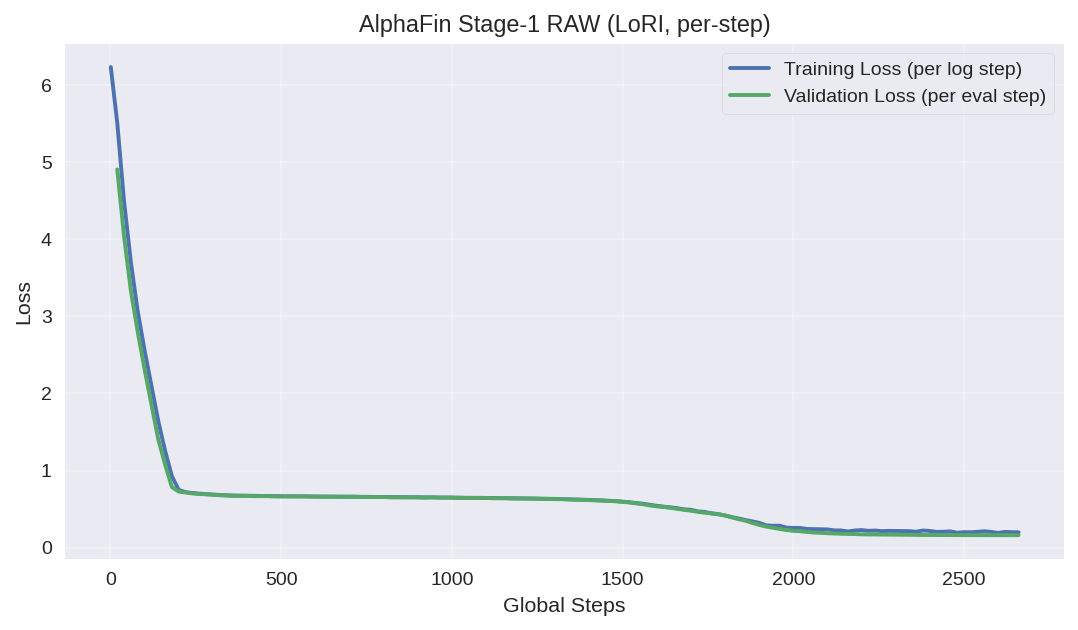

📈 Saved per-step loss curve to: /content/finetuned_stage1_lora/loss_curve_raw_lori_steps.png and Drive


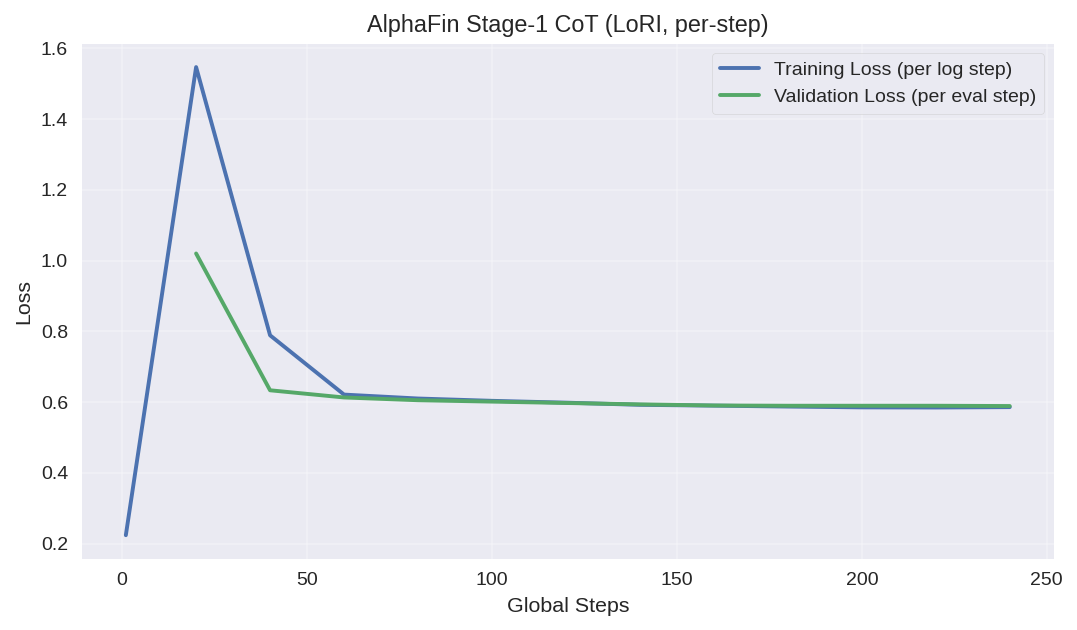

📈 Saved per-step loss curve to: /content/finetuned_stage1_lora/loss_curve_cot_lori_steps.png and Drive
Accuracy: 0.0
Macro-F1: 0.0


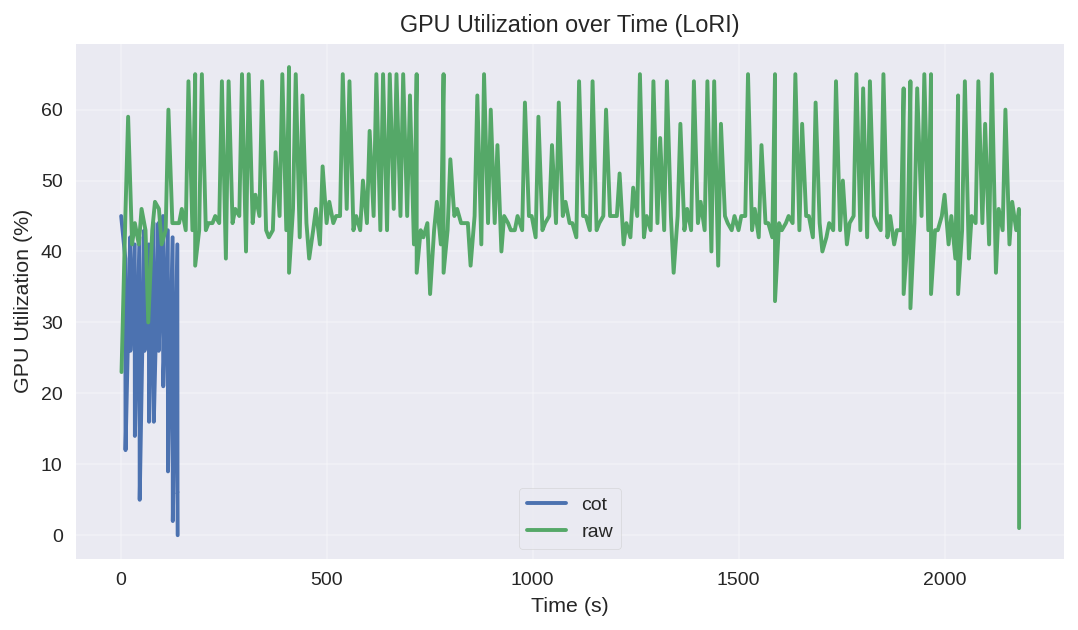

📊 Saved resource curve to: /content/finetuned_stage1_lora/gpu_util_curve_lori.png and Drive


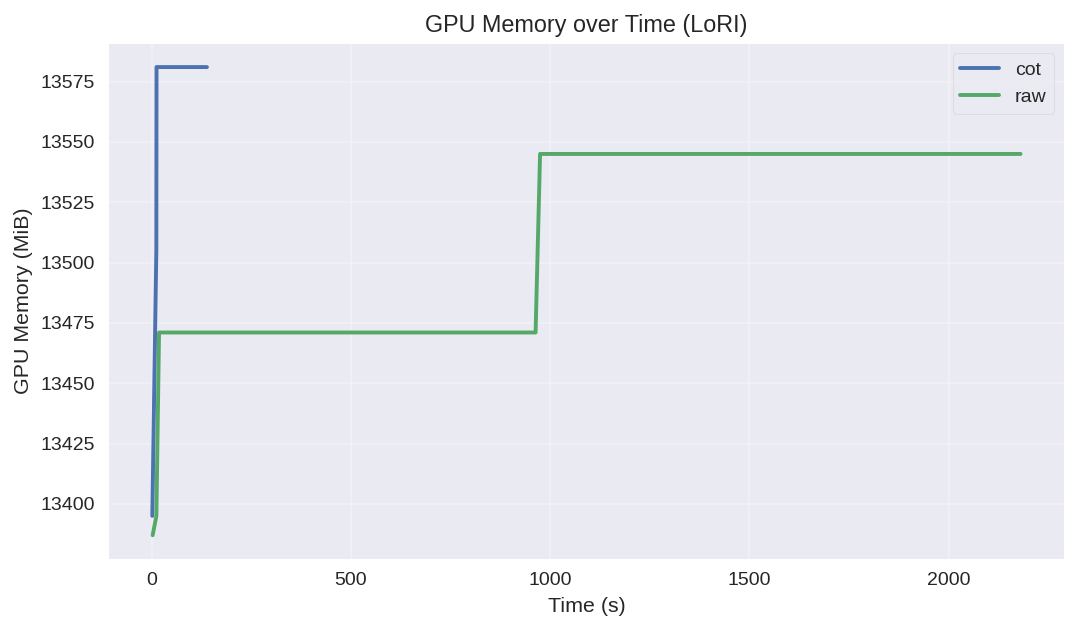

📊 Saved resource curve to: /content/finetuned_stage1_lora/gpu_mem_curve_lori.png and Drive


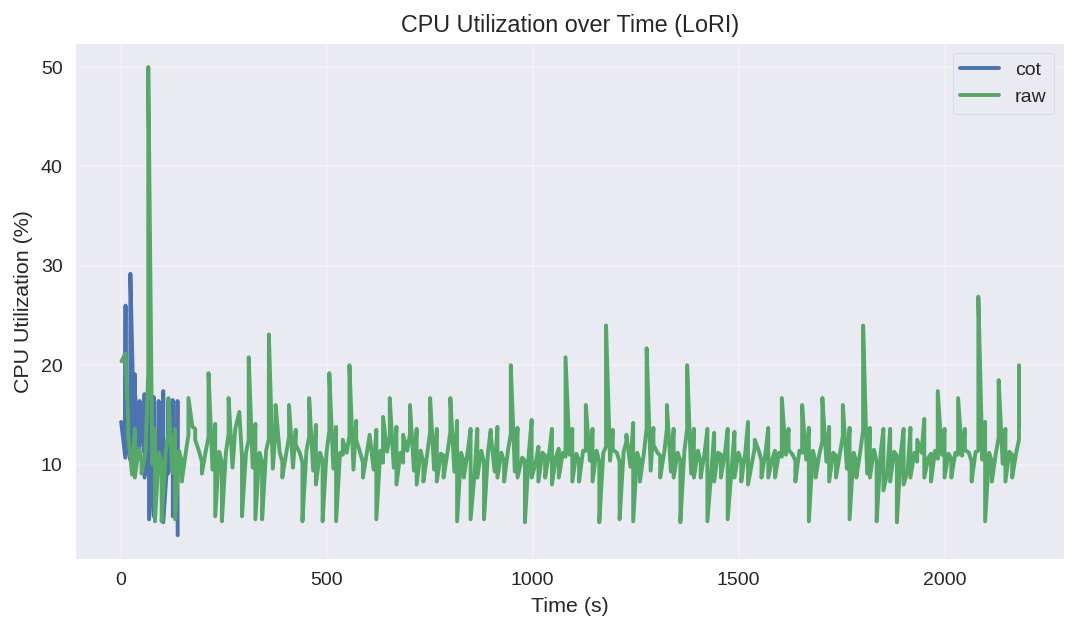

📊 Saved resource curve to: /content/finetuned_stage1_lora/cpu_util_curve_lori.png and Drive


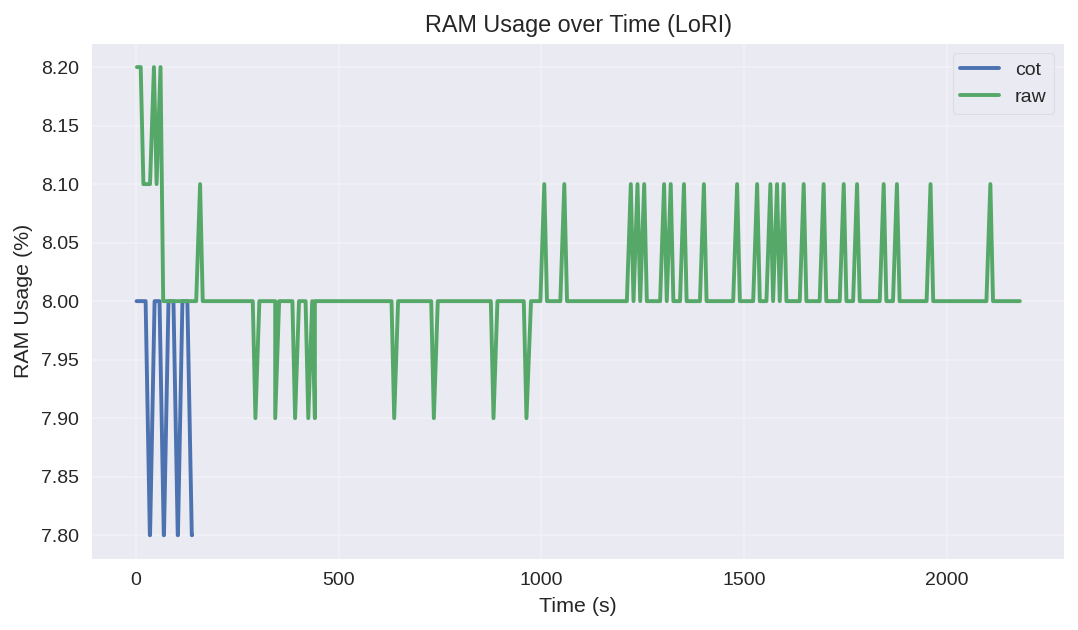

📊 Saved resource curve to: /content/finetuned_stage1_lora/ram_curve_lori.png and Drive
🧾 Saved resource_samples_lori.csv to OUTPUT_DIR and Drive.

===== nvidia-smi snapshot =====
Wed Aug 20 18:43:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P0             68W /  400W |   13581Mi

In [ ]:
# ================================================================
# A100 : LoRI Fine-tuning ( LoRA) on AlphaFin Stage-1
# no quant, no trl | BF16/TF32
# Key Points for LoRI Implementation
# 1) Freeze lora_A as random projection (random proj) and do not train
# 2) Apply task-based sparse masks to lora_B (RAW/CoT two-stage different masks and random seeds)
# 3) During training, enforce re-mask at the end of each step to prevent the optimizer from writing back the masked elements
# 4) Continuously evaluate step by step (triggered at on_log to ensure that the training loss has been written), avoiding "No log"
# 5) Early Stop: Tolerance =5, and it is only allowed to be triggered after at least half an epoch of training
# 6) Independent test set evaluation uses self-written greedy decoding (without calling generate) to avoid compatibility issues with older versions
# ================================================================
import os, sys, re, json, shutil, time, subprocess, psutil, torch, inspect, math
from pathlib import Path
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, TrainingArguments, Trainer, TrainerCallback
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from IPython.display import display

# ---------------- Path ----------------
CHATGLM_DIR = globals().get("CHATGLM_DIR", "/content/alphafin_local/chatglm2")
FINGPT_DIR  = globals().get("FINGPT_DIR" , "/content/alphafin_local/fingpt_lora")
DATA_DIR    = globals().get("DATA_DIR"   , "/content/alphafin_local/AlphaFin_data")
OUTPUT_DIR  = globals().get("OUTPUT_DIR" , "/content/finetuned_stage1_lora")
print(f"Base={CHATGLM_DIR}\nLoRA/LoRI base={FINGPT_DIR}\nData={DATA_DIR}\nOut ={OUTPUT_DIR}")

# ---------------- Google Drive: ----------------
DRIVE_DIR = "/content/drive/My Drive/AlphaFin_Fineturning"
try:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=False)
    os.makedirs(DRIVE_DIR, exist_ok=True)
except Exception:
    pass

assert torch.cuda.is_available(), "请先在 Colab/AutoDL 切到 GPU 运行时。"
device = torch.device("cuda", 0)
cc = torch.cuda.get_device_capability(0)   # (8,0) for A100
A100_BF16 = (cc[0] >= 8)

# A100 : General acceleration: TF32 / matmul high precision
torch.backends.cuda.matmul.allow_tf32 = True
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

# Training/data parameters / (AlphaFin + A100 )
MAX_LEN          = 512
BATCH_PER_DEV    = 4       # 4 * 4 = 16 batch
GRAD_ACCUM_STEPS = 4
EPOCHS_RAW       = 4       # AlphaFin Stage-1 Raw
EPOCHS_COT       = 20      # AlphaFin Stage-1 CoT
NUM_WORKERS      = 8
USE_GRAD_CHKPT   = False
LEARNING_RATE    = 5e-5    # AlphaFin suggestion
print(f"Effective batch size = {BATCH_PER_DEV * GRAD_ACCUM_STEPS}")

# LoRI 
LORI_SPARSITY_RAW = 0.50   # The sparsity rate of RAW stage B (0-1)
LORI_SPARSITY_COT = 0.50   # The sparsity rate of CoT stage B (0-1)
LORI_SEED_RAW     = 1234
LORI_SEED_COT     = 5678
LORI_REINIT_A     = True   #  Whether to reset A to random projection

PROMPT = (
    "请根据以下研究报告与市场数据，预测该股票下月走势，只回答 up 或 down。\n"
    "<report>\n{report}\n"
    "<market_data>\n{market}\n"
    "答案："
)

# ---------------- Tokenizer ----------------
tokenizer = AutoTokenizer.from_pretrained(CHATGLM_DIR, trust_remote_code=True)
tokenizer.padding_side = "left"
PAD_ID = getattr(tokenizer, "pad_token_id", None) or getattr(tokenizer, "eos_token_id", None) or 0
print("PAD_ID =", PAD_ID)

if hasattr(tokenizer, "_pad"):
    try:
        sig = inspect.signature(tokenizer._pad)
        if "padding_side" not in sig.parameters:
            _orig_pad = tokenizer._pad
            def _pad_compat(*args, **kwargs):
                kwargs.pop("padding_side", None)
                return _orig_pad(*args, **kwargs)
            tokenizer._pad = _pad_compat
    except Exception:
        pass

# ----------------Dataset construction----------------
def build_dataset(json_file, tokenizer, max_len=MAX_LEN, desc="Tokenizing"):
    ds = load_dataset("json", data_files=str(json_file), split="train")
    def _map(ex):
        text = PROMPT.format(
            report = ex.get("report", ex.get("text","")),
            market = ex.get("market_data","")
        ) + ex.get("label","")
        ids = tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=max_len)
        return {"input_ids": ids, "labels": ids.copy()}
    return ds.map(_map, remove_columns=ds.column_names, desc=desc)

# ---------------- Block bitsandbytes (Prevent triton.ops)----------------
def disable_bitsandbytes():
    try:
        import bitsandbytes
        print("↯ Detected bitsandbytes, uninstalling…")
        subprocess.run([sys.executable, "-m", "pip", "uninstall", "-y", "bitsandbytes"],
                       check=False, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    except Exception:
        pass
    for k in list(sys.modules.keys()):
        if k.startswith("bitsandbytes"):
            del sys.modules[k]
disable_bitsandbytes()

# ---------------- Stable loading: CPU(FP32) → GPU, then switch to BF16/FP16 ----------------
print("Loading ChatGLM2-6B via CPU(FP32) → GPU …")
base = AutoModel.from_pretrained(
    CHATGLM_DIR,
    torch_dtype=torch.float32,    # CPU FP32
    device_map="cpu",
    trust_remote_code=True,
    low_cpu_mem_usage=False,      #  Turn off meta and avoid invalid arguments
)
base = base.to(device)            #  Move to GPU
base = base.to(dtype=(torch.bfloat16 if A100_BF16 else torch.float16))

# GPU memory/Speed settings
if USE_GRAD_CHKPT:
    try:
        base.gradient_checkpointing_enable(gradient_checkpointing_kwargs={"use_reentrant": False})
    except TypeError:
        base.gradient_checkpointing_enable()
else:
    base.gradient_checkpointing_disable()
base.config.use_cache = False
try: base.config.pad_token_id = PAD_ID
except Exception: pass
print("model device:", next(base.parameters()).device, "| dtype:", next(base.parameters()).dtype)

# ---------------- Mount FinGPT LoRA (then converted to LoRI constraints) ----------------
from peft import PeftModel
model = PeftModel.from_pretrained(base, FINGPT_DIR, is_trainable=True)
print("LoRA (pre-LoRI) on:", next(model.parameters()).device, "| dtype:", next(model.parameters()).dtype)

# ----------------LoRI conversion: Freeze A= Random projection; Mask B ----------------
def _orthogonal_(w):
    try:
        torch.nn.init.orthogonal_(w)
    except Exception:
        torch.nn.init.normal_(w, mean=0.0, std=0.02)

def apply_lori_randomA_and_maskB(model, sparsity: float, seed: int, reinit_A=True):
    """
    对所有 LoRA 层：
      - 若 reinit_A：重置 lora_A.*.weight 为随机（正交/正态），并冻结 A
      - 为 lora_B.*.weight 生成二值掩码（1-稀疏率为保留比例），保存为 buffer：B.lori_mask
    For all LoRA layers:
    - If reinit_A: reset lora_A.*.weight to random (orthogonal/normal) and freeze A
    - Generate a binary mask for lora_B.*.weight (1- sparsity is the retention ratio), and save it as buffer: b.lor_mask
    """
    torch.manual_seed(seed)
    masked_B_modules = []
    for mod in model.modules():
        if hasattr(mod, "lora_A") and hasattr(mod, "lora_B"):
            for adap_name in list(mod.lora_A.keys()):
                A = mod.lora_A[adap_name]
                B = mod.lora_B[adap_name]
                # 1) A: reinit + freeze
                if reinit_A and hasattr(A, "weight"):
                    with torch.no_grad(): _orthogonal_(A.weight)
                    for p in A.parameters(): p.requires_grad = False
                # 2) B: 
                if hasattr(B, "weight"):
                    mask = (torch.rand_like(B.weight) > sparsity).to(B.weight.dtype).to(B.weight.device)
                    B.register_buffer("lori_mask", mask, persistent=False)
                    masked_B_modules.append(B)
    return masked_B_modules

# RAW stage mask & A freeze
masked_B_RAW = apply_lori_randomA_and_maskB(
    model, sparsity=LORI_SPARSITY_RAW, seed=LORI_SEED_RAW, reinit_A=LORI_REINIT_A
)
print(f"LoRI applied for RAW: masked B modules = {len(masked_B_RAW)}, sparsity={LORI_SPARSITY_RAW}")

# Force a mask at the end of each step
class LoRIMaskEnforcer(TrainerCallback):
    def __init__(self, get_masked_B_fn):
        self.get_masked_B_fn = get_masked_B_fn
    def on_step_end(self, args, state, control, **kwargs):
        for B in self.get_masked_B_fn():
            if hasattr(B, "lori_mask"):
                with torch.no_grad():
                    B.weight.data.mul_(B.lori_mask)

# ----------------Data (with tqdm) + validation segmentation (5%) ----------------
raw_full = build_dataset(Path(DATA_DIR)/"train/fin_reports_raw.json", tokenizer, desc="🔄 Tokenizing RAW")
cot_full = build_dataset(Path(DATA_DIR)/"train/fin_reports_cot.json", tokenizer, desc="🔄 Tokenizing CoT")
raw_splits = raw_full.train_test_split(test_size=0.05, seed=42)
cot_splits = cot_full.train_test_split(test_size=0.05, seed=42)
train_raw, valid_raw = raw_splits["train"], raw_splits["test"]
train_cot, valid_cot = cot_splits["train"], cot_splits["test"]

# Independent test set (independent from training/validation)
test_ds = load_dataset(
    "json", data_files=str(Path(DATA_DIR)/"test/1000_report_marketdata.json"), split="train"
)

# ---------------- Collate(Return the CPU tensor → Move the Trainer asynchronously to the GPU) ----------------
def collate_fn(features):
    ids  = [torch.tensor(f["input_ids"], dtype=torch.long) for f in features]
    labs = [torch.tensor(f["labels"],    dtype=torch.long) for f in features]
    ids_p  = pad_sequence(ids,  batch_first=True, padding_value=PAD_ID)
    labs_p = pad_sequence(labs, batch_first=True, padding_value=-100)
    attn   = (ids_p != PAD_ID).long()
    return {"input_ids": ids_p, "labels": labs_p, "attention_mask": attn}

# ---------------- TrainingArguments (Compatible packaging for Transformer) ----------------
def TA(**kwargs):
    sig = inspect.signature(TrainingArguments.__init__)
    params = set(sig.parameters.keys())
    allowed = {k: v for k, v in kwargs.items() if k in params}
    for k in ["evaluation_strategy", "save_strategy", "load_best_model_at_end",
              "metric_for_best_model", "greater_is_better", "eval_steps", "save_steps",
              "logging_strategy", "logging_first_step"]:
        if k not in params:
            allowed.pop(k, None)
    return TrainingArguments(**allowed)

# ----------------Computing Resource monitoring----------------
class ResourceMonitor(TrainerCallback):
    def __init__(self, tag):
        self.tag = tag; self.t0 = time.time(); self.logs = []
    def sample(self, step=None):
        try:
            out = subprocess.check_output(
                ["nvidia-smi", "--query-gpu=utilization.gpu,memory.used",
                 "--format=csv,noheader,nounits"], encoding="utf-8"
            ).strip().splitlines()[0]
            gpu_util, gpu_mem = [int(x.strip()) for x in out.split(",")]
        except Exception:
            gpu_util, gpu_mem = -1, -1
        try:
            cpu_util = psutil.cpu_percent(interval=None); ram = psutil.virtual_memory().percent
        except Exception:
            cpu_util, ram = -1, -1
        self.logs.append({"t": time.time()-self.t0, "step": step or -1,
                          "gpu_util": gpu_util, "gpu_mem": gpu_mem,
                          "cpu_util": cpu_util, "ram": ram, "phase": self.tag})
    def on_log(self, args, state, control, logs=None, **kwargs):
        self.sample(step=int(state.global_step))

# ---------------- Continuous assessment (triggered on on_log) + early stop (at least half) ----------------
class EvalEveryNSteps(TrainerCallback):
    """When on_log is written to the Training Loss, evaluate is triggered at a fixed number of steps to avoid the table showing 'Training Loss = No log'."""
    def __init__(self, eval_steps):
        self.eval_steps = max(1, int(eval_steps))
        self.trainer = None; self._last_eval_step = -1
    def set_trainer(self, t): self.trainer = t
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None or "loss" not in logs:   # Training loss
            return
        step = int(state.global_step or 0)
        if step > 0 and (step % self.eval_steps == 0) and step != self._last_eval_step:
            if self.trainer is not None and self.trainer.eval_dataset is not None:
                metrics = self.trainer.evaluate()
                metrics = dict(metrics); metrics.setdefault("step", step)
                self.trainer.log(metrics)
                self._last_eval_step = step

class EarlyStopMinEpochs(TrainerCallback):
    """patience (based on the number of evaluations). It is triggered only when epoch >= min_epochs; Monitor eval_loss (the smaller, the better)"""
    def __init__(self, patience=5, min_epochs=1, metric="eval_loss", smaller_is_better=True):
        self.patience = int(patience); self.min_epochs = int(min_epochs)
        self.metric = metric; self.smaller_is_better = smaller_is_better
        self.best = None; self.bad = 0
    def _is_better(self, cur, best):
        if best is None: return True
        return (cur < best) if self.smaller_is_better else (cur > best)
    def on_evaluate(self, args, state, control, metrics, **kwargs):
        cur = metrics.get(self.metric, None); epoch = float(state.epoch or 0.0)
        if cur is None: return
        if self._is_better(cur, self.best):
            self.best = cur; self.bad = 0
        else:
            self.bad += 1
            if (epoch >= self.min_epochs) and (self.bad >= self.patience):
                control.should_training_stop = True

# ---------------- Training arguments ----------------
common_args = dict(
    per_device_train_batch_size = BATCH_PER_DEV,
    gradient_accumulation_steps = GRAD_ACCUM_STEPS,
    learning_rate               = LEARNING_RATE,
    lr_scheduler_type           = "cosine",
    optim                       = "adamw_torch_fused",
    bf16                        = A100_BF16,
    fp16                        = not A100_BF16,
    logging_steps               = 20,
    report_to                   = "none",
    disable_tqdm                = False,
    dataloader_pin_memory       = True,
    dataloader_num_workers      = NUM_WORKERS,
    dataloader_prefetch_factor  = 4,
)
EVAL_EVERY_STEPS = common_args["logging_steps"]

# ---------------- Step 1: RAW (LoRI mask = RAW) ----------------
monitor_raw       = ResourceMonitor("raw")
mask_enforcer_raw = LoRIMaskEnforcer(lambda: masked_B_RAW)
step_eval_raw     = EvalEveryNSteps(EVAL_EVERY_STEPS)
earlystop_raw     = EarlyStopMinEpochs(
    patience=5,
    min_epochs=max(1, math.ceil(EPOCHS_RAW * 0.5)),
    metric="eval_loss",
    smaller_is_better=True
)

trainer_raw = Trainer(
    model=model,
    args=TA(
        output_dir="/content/run_raw",
        num_train_epochs=EPOCHS_RAW,
        evaluation_strategy="no",      # ()
        save_strategy="epoch",
        eval_steps=EVAL_EVERY_STEPS,   # 
        save_steps=EVAL_EVERY_STEPS,   # 
        logging_strategy="steps",      # 
        logging_first_step=True,       # 
        **common_args
    ),
    train_dataset=train_raw,
    eval_dataset=valid_raw,
    tokenizer=tokenizer,
    data_collator=collate_fn,
    callbacks=[monitor_raw, mask_enforcer_raw, step_eval_raw, earlystop_raw],
)
step_eval_raw.set_trainer(trainer_raw)
trainer_raw.train()

# ----------------Step 2: Switch to the CoT stage: Replace the LoRI mask ----------------
masked_B_COT = apply_lori_randomA_and_maskB(
    model, sparsity=LORI_SPARSITY_COT, seed=LORI_SEED_COT, reinit_A=False  # A , 
)
print(f"LoRI applied for CoT: masked B modules = {len(masked_B_COT)}, sparsity={LORI_SPARSITY_COT}")
mask_enforcer_cot = LoRIMaskEnforcer(lambda: masked_B_COT)

monitor_cot   = ResourceMonitor("cot")
step_eval_cot = EvalEveryNSteps(EVAL_EVERY_STEPS)
earlystop_cot = EarlyStopMinEpochs(
    patience=5,
    min_epochs=max(1, math.ceil(EPOCHS_COT * 0.5)),
    metric="eval_loss",
    smaller_is_better=True
)

trainer_cot = Trainer(
    model=model,
    args=TA(
        output_dir="/content/run_cot",
        num_train_epochs=EPOCHS_COT,
        evaluation_strategy="no",      # : 
        save_strategy="epoch",
        eval_steps=EVAL_EVERY_STEPS,
        save_steps=EVAL_EVERY_STEPS,
        logging_strategy="steps",
        logging_first_step=True,
        **common_args
    ),
    train_dataset=train_cot,
    eval_dataset=valid_cot,
    tokenizer=tokenizer,
    data_collator=collate_fn,
    callbacks=[monitor_cot, mask_enforcer_cot, step_eval_cot, earlystop_cot],
)
step_eval_cot.set_trainer(trainer_cot)
trainer_cot.train()

# ----------------Save LoRI to Google Drive ----------------
os.makedirs(OUTPUT_DIR, exist_ok=True)
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
dst = f"{DRIVE_DIR}/finetuned_stage1_lora_lori"
try:
    shutil.copytree(OUTPUT_DIR, dst, dirs_exist_ok=True)
    print("LoRI Adapter copied to", dst)
except Exception as e:
    print("拷贝到 Google Drive 失败：", e)

# ============================================================
# 1) / Validation loss(epoch + per-step)
# ============================================================
plt.style.use("seaborn-v0_8")

def _epoch_curves_from_logs(log_hist):
    trn = {}; val = {}
    for rec in log_hist:
        ep = rec.get("epoch", None)
        if ep is None: continue
        if "loss" in rec:      trn.setdefault(ep, []).append(float(rec["loss"]))
        if "eval_loss" in rec: val[ep] = float(rec["eval_loss"])
    te = sorted(trn.keys()); tl = [sum(trn[e])/max(1,len(trn[e])) for e in te]
    ve = sorted(val.keys());  vl = [val[e] for e in ve]
    return (te, tl), (ve, vl)

def _step_curves_from_logs(log_hist):
    ts, tl = [], []; es, ev = [], []
    for rec in log_hist:
        st = rec.get("step", rec.get("global_step", None))
        if st is None: continue
        if "loss" in rec:      ts.append(int(st)); tl.append(float(rec["loss"]))
        if "eval_loss" in rec: es.append(int(st)); ev.append(float(rec["eval_loss"]))
    return (ts, tl), (es, ev)

def _plot_epoch_loss(trainer, title, save_name):
    (te, tl), (ve, vl) = _epoch_curves_from_logs(trainer.state.log_history)
    fig, ax = plt.subplots(figsize=(7.5, 4.6), dpi=140)
    if te: ax.plot(te, tl, marker="o", linewidth=2.2, label="Training Loss (epoch avg)")
    if ve: ax.plot(ve, vl, marker="s", linewidth=2.2, label="Validation Loss (epoch end)")
    ax.set_xlabel("Epochs"); ax.set_ylabel("Loss"); ax.set_title(title)
    ax.grid(True, alpha=0.25); ax.legend(frameon=True)
    fig.tight_layout()
    path_local = os.path.join(OUTPUT_DIR, save_name); fig.savefig(path_local, bbox_inches="tight")
    display(fig); plt.close(fig)
    try:
        shutil.copy(path_local, os.path.join(DRIVE_DIR, save_name))
        print("Saved epoch loss curve to:", path_local, "and Drive")
    except Exception as e:
        print("Save epoch loss curve to Drive failed:", e)

def _plot_step_loss(trainer, title, save_name):
    (ts, tl), (es, ev) = _step_curves_from_logs(trainer.state.log_history)
    fig, ax = plt.subplots(figsize=(7.8, 4.6), dpi=140)
    if ts: ax.plot(ts, tl, linewidth=2.0, label="Training Loss (per log step)")
    if es: ax.plot(es, ev, linewidth=2.0, label="Validation Loss (per eval step)")
    ax.set_xlabel("Global Steps"); ax.set_ylabel("Loss"); ax.set_title(title)
    ax.grid(True, alpha=0.25); ax.legend(frameon=True)
    fig.tight_layout()
    path_local = os.path.join(OUTPUT_DIR, save_name); fig.savefig(path_local, bbox_inches="tight")
    display(fig); plt.close(fig)
    try:
        shutil.copy(path_local, os.path.join(DRIVE_DIR, save_name))
        print("Saved per-step loss curve to:", path_local, "and Drive")
    except Exception as e:
        print("Save per-step loss curve to Drive failed:", e)

_plot_epoch_loss(trainer_raw, "AlphaFin Stage-1 RAW (LoRI, epoch)", "loss_curve_raw_lori.png")
_plot_epoch_loss(trainer_cot, "AlphaFin Stage-1 CoT (LoRI, epoch)", "loss_curve_cot_lori.png")
_plot_step_loss(trainer_raw, "AlphaFin Stage-1 RAW (LoRI, per-step)", "loss_curve_raw_lori_steps.png")
_plot_step_loss(trainer_cot, "AlphaFin Stage-1 CoT (LoRI, per-step)", "loss_curve_cot_lori_steps.png")

# ============================================================
# 2) Independent test set Evaluation (Accuracy & Macro-F1)
# ============================================================
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def infer(prompt, max_new_tokens=8):
    model.eval()
    toks = tokenizer(prompt, return_tensors="pt", add_special_tokens=True)
    input_ids = toks["input_ids"].to(device)
    attn = (input_ids != PAD_ID).long().to(device)

    with torch.no_grad():
        cur_ids  = input_ids
        cur_attn = attn
        for _ in range(max_new_tokens):
            out = model(input_ids=cur_ids, attention_mask=cur_attn)
            logits = out.logits if hasattr(out, "logits") else out[0]
            next_id = int(torch.argmax(logits[:, -1, :], dim=-1))
            next_id_tensor = torch.tensor([[next_id]], device=device, dtype=cur_ids.dtype)
            cur_ids  = torch.cat([cur_ids, next_id_tensor], dim=1)
            add_mask = torch.ones((cur_attn.size(0), 1), dtype=cur_attn.dtype, device=device)
            cur_attn = torch.cat([cur_attn, add_mask], dim=1)
            eos_id = getattr(tokenizer, "eos_token_id", None)
            if eos_id is not None and next_id == eos_id:
                break

    txt = tokenizer.decode(cur_ids[0], skip_special_tokens=True)
    m = re.search(r"(up|down)", txt, re.I)
    return m.group(1).lower() if m else "unknown"

y_true, y_pred = [], []
for ex in test_ds:
    pr = PROMPT.format(report=ex.get("report", ex.get("text","")),
                       market=ex.get("market_data",""))
    y_true.append(ex.get("label",""))
    y_pred.append(infer(pr))

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Macro-F1:", f1_score(y_true, y_pred, average="macro"))

# ============================================================
# 3) GPU/CPU utilization curve (Displays and saves locally & Drive)
# ============================================================
import pandas as pd
def to_df(monitor):
    if not monitor.logs:
        return pd.DataFrame(columns=["t","step","gpu_util","gpu_mem","cpu_util","ram","phase"])
    return pd.DataFrame(monitor.logs)

df_raw = to_df(monitor_raw)
df_cot = to_df(monitor_cot)
df_all = pd.concat([df_raw, df_cot], ignore_index=True)

def _plot_resource(df, y, ylabel, title, save_name):
    if df.empty:
        print("No resource samples for", title); return
    fig, ax = plt.subplots(figsize=(7.8, 4.6), dpi=140)
    for phase, g in df.groupby("phase"):
        ax.plot(g["t"], g[y], label=phase, linewidth=2.0)
    ax.set_xlabel("Time (s)"); ax.set_ylabel(ylabel); ax.set_title(title)
    ax.grid(True, alpha=0.25); ax.legend(frameon=True)
    fig.tight_layout()
    path_local = os.path.join(OUTPUT_DIR, save_name); fig.savefig(path_local, bbox_inches="tight")
    display(fig); plt.close(fig)
    try:
        shutil.copy(path_local, os.path.join(DRIVE_DIR, save_name))
        print("Saved resource curve to:", path_local, "and Drive")
    except Exception as e:
        print("Save resource curve to Drive failed:", e)

# GPU usage / GPU memory
_plot_resource(df_all, "gpu_util", "GPU Utilization (%)", "GPU Utilization over Time (LoRI)", "gpu_util_curve_lori.png")
_plot_resource(df_all, "gpu_mem",  "GPU Memory (MiB)",   "GPU Memory over Time (LoRI)",     "gpu_mem_curve_lori.png")
# CPU usage/ CPU Memory
_plot_resource(df_all, "cpu_util", "CPU Utilization (%)", "CPU Utilization over Time (LoRI)","cpu_util_curve_lori.png")
_plot_resource(df_all, "ram",      "RAM Usage (%)",        "RAM Usage over Time (LoRI)",      "ram_curve_lori.png")

try:
    df_all.to_csv(os.path.join(OUTPUT_DIR, "resource_samples_lori.csv"), index=False)
    shutil.copy(os.path.join(OUTPUT_DIR, "resource_samples_lori.csv"),
                os.path.join(DRIVE_DIR, "resource_samples_lori.csv"))
    print("Saved resource_samples_lori.csv to OUTPUT_DIR and Drive.")
except Exception as e:
    print("Save resource_samples to Drive failed:", e)

# Print nvidia-smi 
print("\n===== nvidia-smi snapshot =====")
try:
    print(subprocess.check_output(["nvidia-smi"], encoding="utf-8"))
except Exception as e:
    print("nvidia-smi failed:", e)
